<a href="https://colab.research.google.com/github/ShawnLiu119/Segmentation_Embedding_DL/blob/main/Customer_Embedding_EventSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Embedding - Based on Event**

## Key Concept
**Event**: customer event sequence could be product browsing history on website, clicks, in store purchase, transactions </br>
**Doc2Vec**: vectorize the document: Doc2Vec is a neural network-based approach that learns the distributed representation of documents. It is an unsupervised learning technique that maps each document to a fixed-length vector in a high-dimensional space

## Use Case
1. **segmentation** capture behavioral semantics and use these embeddings for audience analysis (e.g. clustering)
2. **recommendation engine** input for the downstream personalization models

## Logical thoughts
Each customer is viewed as a document, orders as sentences, and products as words. Each customer could place multiple orders, while one order could include multiple products

## MLOPs consideration
 The dataset size and compute resources need to be carefully selected because Doc2Vec and subsequent clustering are computationally heavy processes.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm #show progress bar
import numpy as np
import os
from sklearn.manifold import TSNE #visualize high-dimensional data by converting similarity to join probabilities

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob #glob module is used to retrieve files/pathnames matching a specified pattern

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 2


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Read Data

In [4]:
folder = "/content/drive/MyDrive/kaggle_data/instacart-market-basket-analysis"
files_list = glob.glob(f'{folder}/*.csv')

data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(show_counts=True))
    data_dict[file.split('.')[0].split('/')[-1]] = data

print(f'Loaded data sets: {data_dict.keys()}')



Reading: /content/drive/MyDrive/kaggle_data/instacart-market-basket-analysis/sample_submission.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  75000 non-null  int64 
 1   products  75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


Reading: /content/drive/MyDrive/kaggle_data/instacart-market-basket-analysis/order_products__prior.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int64
 1   product_id         32434489 non-null  int64
 2   add_to_cart_order  32434489 non-null  int64
 3   reordered          32434489 non-null  int64
dtypes: int64(4)
memory usage: 989.8 MB
None


Reading: /content/drive/

In [6]:
df_test = data_dict['products']
df_test.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
df_t2 = data_dict['orders']
df_t2.head()
#按照order的时间排序 每个user

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
df_t3 = data_dict['order_products__train']
df_t3.head()
#按照order的时间排序 每个user

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [20]:
df_t4 = data_dict['aisles']
df_t4.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Step 2: Establish Baseline for comparison

note: no demogrphic data avaiable here

### 2.1 Feature Engineer

In [11]:
train_orders = data_dict['order_products__train']
prior_orders = data_dict['order_products__prior']
products = data_dict['products'].set_index('product_id')

orders = data_dict['orders']
prior_orders = prior_orders.merge(right=orders[['user_id','order_id','order_number']],on='order_id',how='left')

prior_orders.head()
#userid --> document, order_id --> sentence, product_id --> word

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [16]:
print(len(prior_orders))
print(prior_orders['order_id'].nunique()) #unique order numbers
print(prior_orders['user_id'].nunique()) #unique order numbers

32434489
3214874
206209


In [17]:
#downsize sample to reduce the computational resource consumption
user_subset = 50000
user_id_sample = prior_orders['user_id'].sample(n=user_subset, replace=False) #replace: do not allow one row to be sampled more than once

In [18]:
type(user_id_sample)

pandas.core.series.Series

In [21]:
prior_orders_details = prior_orders[prior_orders.user_id.isin(user_id_sample)].copy()
prior_orders_details['product_id'] = prior_orders_details['product_id'].astype(int)
prior_orders_details = prior_orders_details.merge(data_dict['products'], on='product_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['aisles'], on='aisle_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['departments'], on='department_id', how='left')

prior_orders_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,product_name,aisle_id,department_id,aisle,department
0,4,46842,1,0,178520,36,Plain Pre-Sliced Bagels,93,3,breakfast bakery,bakery
1,4,26434,2,1,178520,36,Honey/Lemon Cough Drops,11,11,cold flu allergy,personal care
2,4,39758,3,1,178520,36,Chewy 25% Low Sugar Chocolate Chip Granola,3,19,energy granola bars,snacks
3,4,27761,4,1,178520,36,Oats & Chocolate Chewy Bars,48,14,breakfast bars pastries,breakfast
4,4,10054,5,1,178520,36,Kellogg's Nutri-Grain Apple Cinnamon Cereal,48,14,breakfast bars pastries,breakfast


In [45]:
#some feature engineer - relative purchase frequences in each department / aisle

#pivot table, count # of products pruchased per department for each user (2D)
feature_department = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['department'], aggfunc='count', fill_value=0)
feature_department.head()

product_id                                                                                                                                                                                       
department    alcohol babies bakery beverages breakfast bulk canned goods dairy eggs deli dry goods pasta frozen household international meat seafood missing other pantry personal care pets produce snacks
user_id                                                                                                                                                                                                     
14                 13      0     14         2         2    0           11         12    5               9     35         9             3            2       1     6     51             0    0      32      3
20                  0      0      0         0         0    0            0          0    0               0      0         0             0            0       0     0      0             0    0      11     11
27                  0      0     19       345        11    0            0        209    1               0      0         5             4            0       0     0     14             6    0      63     91
28                  0      0      2        11         8    0           12         28    8               3      6         0             1            5       0     0     14             4    2      72      7
31                  5      0      3        76        10    0            6         33   19               0     91         5             1           16       0     0      9             2    0       2     21

In [46]:
feature_department.query("user_id == 14")

product_id                                                                                                                                                                                       
department    alcohol babies bakery beverages breakfast bulk canned goods dairy eggs deli dry goods pasta frozen household international meat seafood missing other pantry personal care pets produce snacks
user_id                                                                                                                                                                                                     
14                 13      0     14         2         2    0           11         12    5               9     35         9             3            2       1     6     51             0    0      32      3

In [47]:
feature_department = feature_department.div(feature_department.sum(axis=1), axis=0) #每个user_id购买的总数，一行所有列加总

In [29]:
type(feature_department.sum(axis=1))

pandas.core.series.Series

In [37]:
feature_department.columns

MultiIndex([('product_id',         'alcohol'),
            ('product_id',          'babies'),
            ('product_id',          'bakery'),
            ('product_id',       'beverages'),
            ('product_id',       'breakfast'),
            ('product_id',            'bulk'),
            ('product_id',    'canned goods'),
            ('product_id',      'dairy eggs'),
            ('product_id',            'deli'),
            ('product_id', 'dry goods pasta'),
            ('product_id',          'frozen'),
            ('product_id',       'household'),
            ('product_id',   'international'),
            ('product_id',    'meat seafood'),
            ('product_id',         'missing'),
            ('product_id',           'other'),
            ('product_id',          'pantry'),
            ('product_id',   'personal care'),
            ('product_id',            'pets'),
            ('product_id',         'produce'),
            ('product_id',          'snacks')],
           n

In [48]:
feature_department.columns = feature_department.columns.droplevel(0)
#本来是有2个index, product_id 和 department, will remove redudant "product_id"

In [49]:
feature_department.columns

Index(['alcohol', 'babies', 'bakery', 'beverages', 'breakfast', 'bulk', 'canned goods', 'dairy eggs', 'deli', 'dry goods pasta', 'frozen', 'household', 'international', 'meat seafood', 'missing', 'other', 'pantry', 'personal care', 'pets', 'produce', 'snacks'], dtype='object', name='department')

In [40]:
feature_department = feature_department.reset_index()

In [52]:
df = feature_department.copy()
df['total'] = df.sum(axis=1)
df['total']

user_id
14        1.0
20        1.0
27        1.0
28        1.0
31        1.0
         ... 
206195    1.0
206197    1.0
206202    1.0
206203    1.0
206208    1.0
Name: total, Length: 38324, dtype: float64

In [53]:
#per aisle basis
feature_aisle = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['aisle'], aggfunc='count', fill_value=0)
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
feature_aisle.columns = feature_aisle.columns.droplevel(0)
feature_aisle = feature_aisle.reset_index()

feature_df = feature_department.merge(feature_aisle, how='left', on='user_id').set_index('user_id')

feature_df.iloc[:5, :10] # show first 10 columns (departments) only

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta
user_id,,,,,,,,,,
14,0.061905,0.0,0.066667,0.009524,0.009524,0.0,0.052381,0.057143,0.023810,0.042857
20,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
27,0.000000,0.0,0.024740,0.449219,0.014323,0.0,0.000000,0.272135,0.001302,0.000000
28,0.000000,0.0,0.010929,0.060109,0.043716,0.0,0.065574,0.153005,0.043716,0.016393
31,0.016722,0.0,0.010033,0.254181,0.033445,0.0,0.020067,0.110368,0.063545,0.000000


In [55]:
#total # feature engineered
len(feature_aisle.columns)

135

### 2.2 Visualize the Basic Space Using t-SNE

In [56]:
from sklearn.preprocessing import MinMaxScaler

mm_scale = MinMaxScaler()
feature_df_scale = pd.DataFrame(mm_scale.fit_transform(feature_df),
                                columns=feature_df.columns,
                                index=feature_df.index.values)


tsne_doc_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500) #mosty perplexity is 5-50
tsne_features_doc = tsne_doc_features.fit_transform(feature_df_scale.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38324 samples in 0.033s...
[t-SNE] Computed neighbors for 38324 samples in 20.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38324
[t-SNE] Computed conditional probabilities for sample 2000 / 38324
[t-SNE] Computed conditional probabilities for sample 3000 / 38324
[t-SNE] Computed conditional probabilities for sample 4000 / 38324
[t-SNE] Computed conditional probabilities for sample 5000 / 38324
[t-SNE] Computed conditional probabilities for sample 6000 / 38324
[t-SNE] Computed conditional probabilities for sample 7000 / 38324
[t-SNE] Computed conditional probabilities for sample 8000 / 38324
[t-SNE] Computed conditional probabilities for sample 9000 / 38324
[t-SNE] Computed conditional probabilities for sample 10000 / 38324
[t-SNE] Computed conditional probabilities for sample 11000 / 38324
[t-SNE] Computed conditional probabilities for sample 12000 / 38324
[t-SNE] Computed conditional probabilities for sa

this time, the scaling is done by column </br>
Centering shouldn't matter since the algorithm only operates on distances between points, **however rescaling is necessary if you want the different dimensions to be treated with equal importance, since the 2-norm will be more heavily influenced by dimensions with large variance.**

In [58]:
type(tsne_features_doc)

numpy.ndarray

In [61]:
tsne_features_doc[:5] #return a numpy array, 2 dimension component wiht index

array([[-17.205223 , -11.300572 ],
       [  6.0913687,  26.585228 ],
       [-18.513454 ,  18.671577 ],
       [ 16.356955 , -16.154768 ],
       [-29.379337 ,  -8.38368  ]], dtype=float32)

In [62]:
tsne_doc_features = pd.DataFrame({'user_id':feature_df.index.values})
tsne_doc_features['tsne-2d-one'] = tsne_features_doc[:,0]
tsne_doc_features['tsne-2d-two'] = tsne_features_doc[:,1]

<Figure size 1600x1600 with 0 Axes>

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

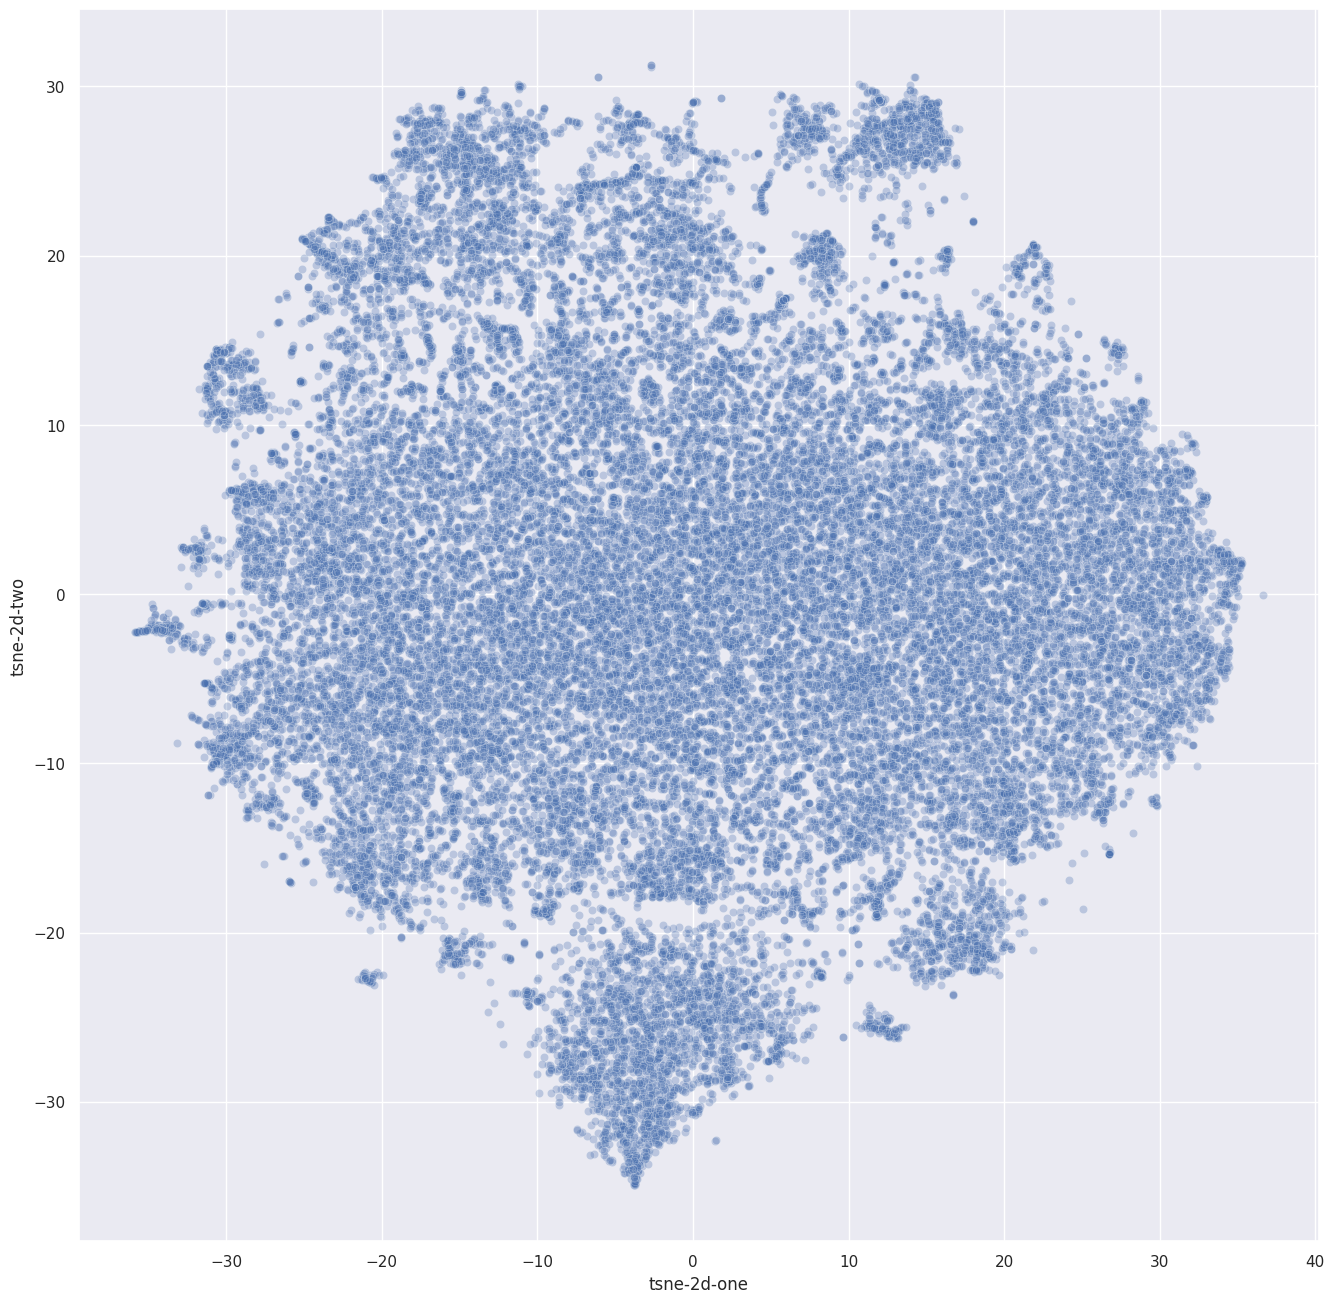

In [63]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc_features,
    legend="full",
    alpha=0.3
)
plt.show()

In [64]:
# Computing silhouette scores for different clustering option
silhouette_list = []
for k in tqdm(range(2, 12, 2)):
    clusters = KMeans(n_clusters=k).fit(feature_df_scale).labels_.astype(float)
    silhouette_avg = silhouette_score(feature_df_scale, clusters, metric="euclidean") #Compute the mean Silhouette Coefficient of all samples.
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

<ipython-input-64-e99ea2c3317b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(2, 12, 2)):


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 2 clusters is : 0.1127


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 4 clusters is : 0.04905


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 6 clusters is : 0.04859


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 8 clusters is : 0.04524


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 10 clusters is : 0.02228


**The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.**

<Figure size 1000x600 with 0 Axes>

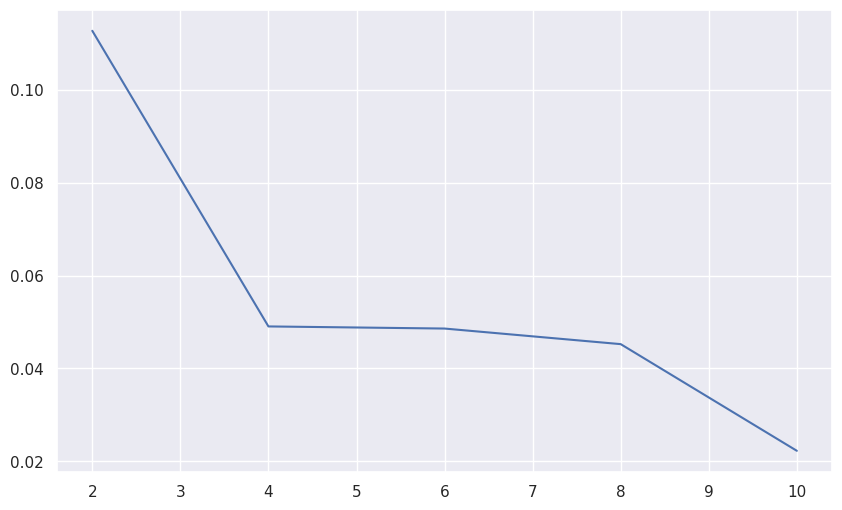

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12, 2), silhouette_list)

Conclusions:
**use traditional ML K means does not work well.** silhouette score越接近1越好
We can see from the t-SNE visualization it is possible to detect 2-3 clusters, but the silhouette score is close to zero and this feature space is not a good choice for customer segmentation. We should develop more advanced features and incorporate more domain knowledge to obtain better feature space for segmentation.

**A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, a silhouette score below 0.25 indicates a bad clustering, and a silhouette score between 0.25 and 0.5 indicates a fair clustering.**

## Step 3: Customer2Vec Using Doc2Vec

### 3.1 Data Prep

In [66]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

# It is important to sort order and products chronologically 按照时间顺序排列
prior_orders.sort_values(by=['user_id','order_number','add_to_cart_order'], inplace=True)

In [67]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
24076664,2539329,196,1,0,1,1
24076665,2539329,14084,2,0,1,1
24076666,2539329,12427,3,0,1,1
24076667,2539329,26088,4,0,1,1
24076668,2539329,26405,5,0,1,1


In [68]:
combined_orders_by_user_id = prior_orders.groupby("user_id").apply(lambda order: ' '.join(order['product_id'].tolist()))

#order here refer a row
#product id will have redudancy, each row is the list of products that are added into cart and purchase in time order.
#index is user id, generate pands.series

In [70]:
type(combined_orders_by_user_id)

pandas.core.series.Series

In [72]:
combined_orders_by_user_id.head()

user_id
1                                                                                                                                                                          196 14084 12427 26088 26405 196 10258 12427 13176 26088 13032 196 12427 10258 25133 30450 196 12427 10258 25133 26405 196 12427 10258 25133 10326 17122 41787 13176 196 12427 10258 25133 196 10258 12427 25133 13032 12427 196 10258 25133 46149 49235 49235 46149 25133 196 10258 12427 196 46149 39657 38928 25133 10258 35951 13032 12427
2    32792 47766 20574 12000 48110 22474 16589 35917 27344 30489 27966 13176 45066 16797 47526 8479 47766 19051 8138 47766 32792 20574 7781 28874 49451 32792 32139 34688 36735 37646 22829 24852 47209 33276 45613 9681 21150 47144 5322 17224 38656 21376 48210 5907 14553 47553 22124 19156 1559 47766 32792 12000 9681 32139 32052 27344 24852 45066 27966 47209 36735 46676 33754 17872 18523 24954 4957 40571 41787 19051 33276 32792 12000 16589 32052 19051 32139 47209 24852 46886 40198 17758

In [73]:
combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of users: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id.user_id = combined_orders_by_user_id.user_id.astype(str)

combined_orders_by_user_id.head()

Number of users: 206209


,user_id,all_orders
0,1,196 14084 12427 26088 26405 196 10258 12427 13176 26088 13032 196 12427 10258 25133 30450 196 12427 10258 25133 26405 196 12427 10258 25133 10326 17122 41787 13176 196 12427 10258 25133 196 10258 12427 25133 13032 12427 196 10258 25133 46149 49235 49235 46149 25133 196 10258 12427 196 46149 39657 38928 25133 10258 35951 13032 12427
1,2,32792 47766 20574 12000 48110 22474 16589 35917 27344 30489 27966 13176 45066 16797 47526 8479 47766 19051 8138 47766 32792 20574 7781 28874 49451 32792 32139 34688 36735 37646 22829 24852 47209 33276 45613 9681 21150 47144 5322 17224 38656 21376 48210 5907 14553 47553 22124 19156 1559 47766 32792 12000 9681 32139 32052 27344 24852 45066 27966 47209 36735 46676 33754 17872 18523 24954 4957 40571 41787 19051 33276 32792 12000 16589 32052 19051 32139 47209 24852 46886 40198 17758 45066 41787 3...
2,3,9387 17668 15143 16797 39190 47766 21903 39922 24810 32402 38596 21903 248 40604 8021 17668 21137 23650 32402 39190 47766 21903 49683 28373 7503 1819 12845 9387 16965 24010 39190 9387 17668 47766 16965 28373 21903 22035 42265 18370 44683 22035 39190 9387 47766 1819 24810 14992 44683 39190 1819 21903 43961 16797 24010 14992 18599 9387 39190 22035 43961 18599 21903 47766 42557 48523 39190 47766 16797 43961 48523 18599 17668 47766 39190 1005 32402 39190 47766 21903 43961 17668 39190 18599 23650...
3,4,36606 7350 35469 2707 42329 7160 1200 17769 43704 37646 11865 35469 19057 22199 25146 26576 25623 21573
4,5,15349 21413 48775 28289 8518 11777 31717 26604 43693 22475 24535 43693 6808 24535 11777 21616 18761 26604 13870 13988 26604 11777 20754 24231 40706 27344 24535 43693 40706 16168 21413 13988 3376 8518 26604 11777 5999


### 3.2 Train Doc2Vec model

documents = users (each user is represented by a chronologically sorted list of products)
window - Maximum distance between the current and predicted word within a sentence.
vector_size - Dimensionality of the word vectors.
min_count - Ignores all words with total frequency lower than this. (products that are bought rarely will be ignored)

In [79]:
TRAIN_USER_MODEL = True    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import timeit
import gensim

embeddings_dim = 200    # dimensionality of user representation

filename = f'models/customer2vec.{embeddings_dim}d.model'
if TRAIN_USER_MODEL:

    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        #Use the __init__() function to assign values to object properties
        #the property for this class is df, with value as df

        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['user_id']])
        # returns an iterator for the given object (array, set, tuple, etc., or custom objects
        #df.itertuples(): Iterate over DataFrame rows as namedtuples., here each row is an user

    #initiate class
    it = TaggedDocumentIterator(combined_orders_by_user_id)

    #initiate model
    doc_model = gensim.models.Doc2Vec(vector_size=embeddings_dim,
                                      window=5,
                                      min_count=10,
                                      workers=mp.cpu_count(),
                                      alpha=0.055,
                                      min_alpha=0.055,
                                      epochs=120)   # use fixed learning rate

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)
    #The build_vocab() step is how the model discovers the set of all possible words/doc-tags – and in the case of words, finds which words occur more than min_count times.

    #start training
    for epoch in tqdm(range(10)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')

else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

**size** <br/>
The size of the dense vector to represent each token or word (i.e. the context or neighboring words). If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, it’s good to experiment with various sizes. A value of 100–150 has worked well for me for similarity lookups.<br/>

**window**<br/>
The maximum distance between the target word and its neighboring word. If your neighbor’s position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related. Again, if your data is not sparse, then the window size should not matter too much, as long as it’s not overly narrow or overly broad. If you are not too sure about this, just use the default value.<br/>

**min_count**<br/>
Minimium frequency count of words. The model would ignore words that do not satisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model in terms of your final results. The settings here probably has more of an effect on memory usage and storage requirements of the model files.